# Various notes on fitting emission lines

In [1]:
import numpy as np
import pylab as pl
import orb.fit
import orb.fft
import orb.utils.fit
import orb.sim

## Bayesian Information Criterion

https://en.wikipedia.org/wiki/Bayesian_information_criterion

This is a good way to compare 2 different models on the same fit. The lowest BIC is the best model. In the least square fit framework, as long as the noise is normally distributed (which is the case with SITELLE spectra) we can write:

$\chi^2 = \sum_{i=1}^{n}{(x_i - \hat{x_i})^2}$

$\text{BIC} = n \ln{\left(\frac{\chi^2}{n}\right)} + k \ln{(n)}$

Where, $n$ is the number of samples (length of the spectrum) and $k$ is the number of parameters. The $\chi^2$ is the sum of the square of the residual. This is automatically computed with ORCS.

In this example we compare a two-components model with a one-component model on a low SNR spectrum.

=== Fit results ===
lines: ['H3', '[NII]6548', '[NII]6584', '[SII]6717', '[SII]6731'], fmodel: sincgauss
iterations: 105, fit time: 5.84e-01 s
number of free parameters: 7, BIC: -1.80505e+03, chi2: 4.29e+00
Velocity (km/s): [79(11) 79(11) 79(11) 79(11) 79(11)] 
Flux: [9.39(67) 0.84(13) 2.53(40) 0.72(40) 0.28(40)]
Broadening (km/s): [190(10) 190(10) 190(10) 190(10) 190(10)]
SNR (km/s): [20.70613363  6.67199224  6.67199224  1.80709523  0.69757399]

=== Fit results ===
lines: ['H3', '[NII]6548', '[NII]6584', '[SII]6717', '[SII]6731', 'H3', '[NII]6548', '[NII]6584', '[SII]6717', '[SII]6731'], fmodel: sincgauss
iterations: 155, fit time: 1.08e+00 s
number of free parameters: 13, BIC: -1.81256e+03, chi2: 3.86e+00
Velocity (km/s): [4(17) 4(17) 4(17) 4(17) 4(17) 305(38) 305(38) 305(38) 305(38) 305(38)] 
Flux: [5.93(85) 0.61(12) 1.84(35) 0.62(30) -0.09(31) 3.56(95) 0.24(12) 0.71(36)
 0.12(32) 0.50(34)]
Broadening (km/s): [110(13) 110(13) 110(13) 110(13) 110(13) 127(30) 127(30) 127(30) 127(30)
 

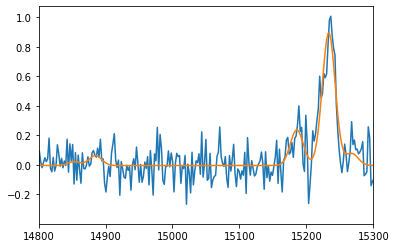

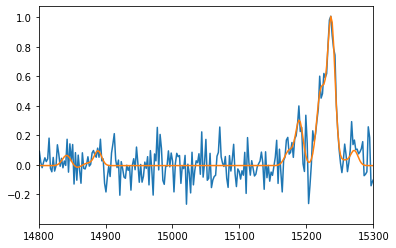

In [2]:
### synthetic spectrum

lines = ['Halpha', '[NII]6548', '[NII]6584', '[SII]6717', '[SII]6731']
amp = np.array([1, 0.1, 0.3, 0.1, 0.1]) # amplitude of the lines
sigma = 100 # line broadening in km/s
vel_diff = 275 # velocity diffrence between both components in km/s
amp2_ratio = 0.5 # ratio between the second component and the first one

step_nb = 850 # resolution ~ 5000
filter_name = 'SN3'
ss = orb.sim.Spectrum(step_nb, filter_name)
ss.add_component(lines, amp, sigma=sigma)
ss.add_component(lines, amp2_ratio * amp, sigma=sigma, vel=vel_diff)
spectrum = ss.get_spectrum()
# add noise
spectrum.data += np.random.standard_normal(size=spectrum.data.size) * 0.1 # SNR 10


### 1 component fit
fit1 = spectrum.fit(lines, fmodel='sincgauss', pos_def='1', pos_cov=0, sigma_def='1', sigma_cov=sigma, 
                   amp_def=['1','2','2','3','4'], amp_guess=[1,1,2.985,1,1])
print(fit1)
spectrum.plot()
fit1.get_spectrum().plot()
pl.xlim(14800, 15300)

### 2 components fit
fit2 = spectrum.fit(lines + lines, fmodel='sincgauss', 
                    pos_def=['1','1','1','1','1', '2','2','2','2','2'], pos_cov=[0, vel_diff], 
                    sigma_def=['1','1','1','1','1', '2','2','2','2','2'], sigma_cov=[sigma, sigma], 
                    amp_def=['1','2','2','3','4', '5','6','6','7','8'], amp_guess=[1,1,2.985,1,1,1,1,2.985,1,1])
print(fit2)
pl.figure()
spectrum.plot()
fit2.get_spectrum().plot()
pl.xlim(14800, 15300)


print('=== BIC COMPARISON ===')
print('if positive and > 2, two component fit is better')
print("""0 to 2 \t\tNot worth more than a bare mention
2 to 6 \t\tPositive
6 to 10 \tStrong
>10 \t\tVery strong """)

print('DELTA BIC =', fit1['BIC'] - fit2['BIC'])